In [60]:
                                     # QuickBooks-style Intelligent Expense Categorization
                                     # ML Model using Text + Numeric Features with XGBoost

# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.sparse import hstack
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
#Load Dataset
df = pd.read_csv("quickbooks_synthetic_expenses_7k_diverse.csv")
print(df.head())

   transaction_id merchant_name                       description  \
0     1744.453683           Jio       Dominos transaction payment   
1     1445.463575       Dominos       Dominos transaction payment   
2      423.968608        Airtel        Airtel transaction payment   
3      288.082971  ACT Fibernet  ACT Fibernet transaction payment   
4     1540.187556        Amazon        Zomato transaction payment   

        amount transaction_date payment_mode       category  
0  1883.928227       2024-04-08  Net Banking  Food & Dining  
1  1386.307369       2024-12-27  Net Banking       Shopping  
2  4749.719533       2024-01-19  Net Banking      Utilities  
3  2200.243580       2024-02-18  Credit Card      Utilities  
4  4457.339661       2024-03-24  Net Banking  Food & Dining  


In [62]:
#Feature Engineering
# Combine merchant name and description into one text feature
df["text"] = df["merchant_name"].astype(str) + " " + df["description"].astype(str)

# Numeric feature: log transform amount for normalization
df["log_amount"] = np.log1p(df["amount"])

# Convert transaction_date to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

# Extract useful date features
df["day_of_week"] = df["transaction_date"].dt.dayofweek
df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
df["month"] = df["transaction_date"].dt.month

# Drop rows with missing critical values
df = df.dropna(subset=["text", "category"])

In [63]:
# Define Features and Target
X = df[["text", "log_amount", "day_of_week", "is_weekend", "month"]]
y = df["category"]

In [64]:
#Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [65]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [66]:
#Text Vectorization (TF-IDF)
tfidf = TfidfVectorizer(
    max_features=20000,      # Cover more words
    ngram_range=(1,3),       # unigrams, bigrams, trigrams
    stop_words="english",
    min_df=3
)


In [67]:
# Fit on training text and transform both train & test
X_train_tfidf = tfidf.fit_transform(X_train["text"])
X_test_tfidf = tfidf.transform(X_test["text"])


In [68]:
#Numeric Features Scaling
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[["log_amount", "day_of_week", "is_weekend", "month"]])
X_test_num = scaler.transform(X_test[["log_amount", "day_of_week", "is_weekend", "month"]])


In [69]:
# Combine Text + Numeric Features
X_train_final = hstack([X_train_tfidf, X_train_num])
X_test_final = hstack([X_test_tfidf, X_test_num])


In [70]:
#Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=len(label_encoder.classes_),
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    use_label_encoder=False
)

xgb_model.fit(X_train_final, y_train_enc)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [15:33:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, num_class=6, ...)

In [71]:
# Evaluate Model
y_pred_enc = xgb_model.predict(X_test_final)
y_pred = label_encoder.inverse_transform(y_pred_enc)

# Accuracy
print("✅ Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


✅ Accuracy: 0.7128571428571429

Classification Report:

               precision    recall  f1-score   support

Entertainment       0.67      0.69      0.68       228
Food & Dining       0.70      0.71      0.71       221
       Health       0.71      0.72      0.71       241
     Shopping       0.73      0.77      0.75       222
       Travel       0.78      0.69      0.73       240
    Utilities       0.69      0.70      0.69       248

     accuracy                           0.71      1400
    macro avg       0.71      0.71      0.71      1400
 weighted avg       0.71      0.71      0.71      1400



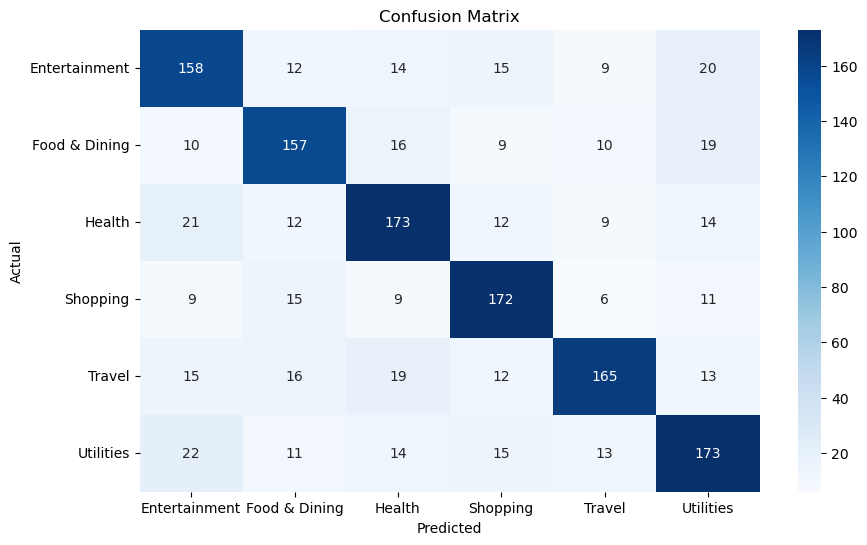

In [72]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

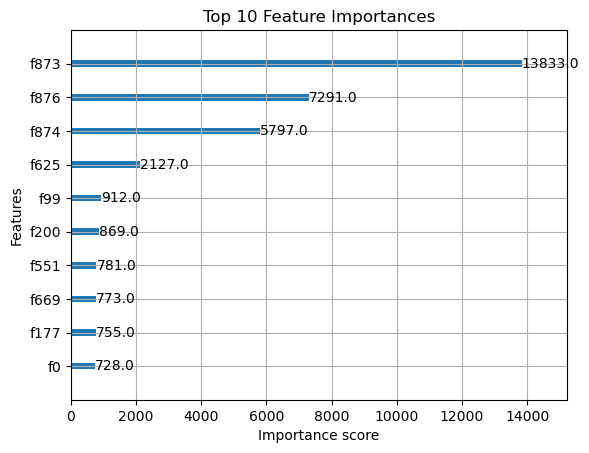

In [73]:
# Feature Importance Plot
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()


In [74]:
#Confidence-Based Predictions
probs = xgb_model.predict_proba(X_test_final)  # predicted probabilities
max_probs = probs.max(axis=1)  # max probability per sample

# Apply confidence threshold (example: 60%)
threshold = 0.6
final_preds = [
    label_encoder.inverse_transform([pred_enc])[0] if prob >= threshold else "Needs Review"
    for pred_enc, prob in zip(y_pred_enc, max_probs)
]

# Display first 10 predictions
for i in range(10):
    print(f"Actual: {y_test.iloc[i]}, Prediction: {final_preds[i]}, Confidence: {max_probs[i]:.2f}")


Actual: Utilities, Prediction: Utilities, Confidence: 0.79
Actual: Travel, Prediction: Travel, Confidence: 0.73
Actual: Utilities, Prediction: Utilities, Confidence: 0.82
Actual: Travel, Prediction: Travel, Confidence: 0.84
Actual: Health, Prediction: Food & Dining, Confidence: 0.90
Actual: Shopping, Prediction: Needs Review, Confidence: 0.52
Actual: Health, Prediction: Health, Confidence: 0.91
Actual: Utilities, Prediction: Needs Review, Confidence: 0.53
Actual: Food & Dining, Prediction: Utilities, Confidence: 0.81
Actual: Food & Dining, Prediction: Food & Dining, Confidence: 0.75


Predicted Category: Food & Dining
Prediction Confidence: 60.23%
⚠️ Low confidence! Recommend manual review.


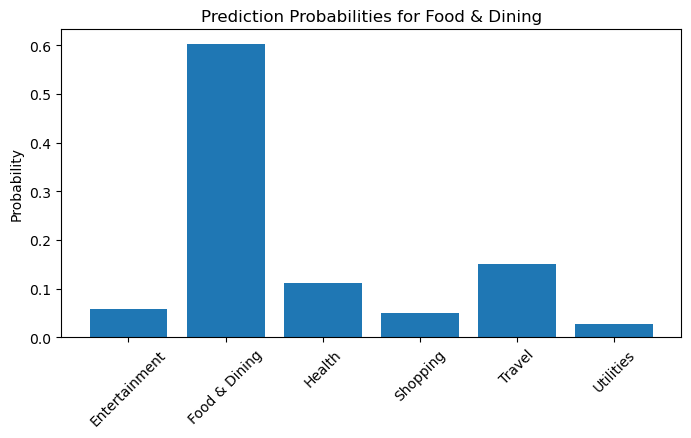

In [75]:
#Predict on New Sample
sample = pd.DataFrame({
    "merchant_name": ["Starbucks"],
    "description": ["Coffee and snacks"],
    "amount": [5.75],
    "transaction_date": [pd.to_datetime("2026-02-02")]
})

# Preprocess sample
sample["text"] = sample["merchant_name"] + " " + sample["description"]
sample["log_amount"] = np.log1p(sample["amount"])
sample["day_of_week"] = sample["transaction_date"].dt.dayofweek
sample["is_weekend"] = sample["day_of_week"].isin([5,6]).astype(int)
sample["month"] = sample["transaction_date"].dt.month

# Transform features
sample_tfidf = tfidf.transform(sample["text"])
sample_num = scaler.transform(sample[["log_amount", "day_of_week", "is_weekend", "month"]])
sample_final = hstack([sample_tfidf, sample_num])

# Prediction and confidence
pred_enc = xgb_model.predict(sample_final)[0]
pred_class = label_encoder.inverse_transform([pred_enc])[0]
proba = xgb_model.predict_proba(sample_final)
confidence = np.max(proba) * 100  # percentage

print(f"Predicted Category: {pred_class}")
print(f"Prediction Confidence: {confidence:.2f}%")

# Threshold for manual review
manual_threshold = 80
if confidence < manual_threshold:
    print("⚠️ Low confidence! Recommend manual review.")
else:
    print("✅ High confidence prediction!")

# Optional: visualize probabilities
plt.figure(figsize=(8,4))
plt.bar(label_encoder.classes_, proba[0])
plt.ylabel("Probability")
plt.title(f"Prediction Probabilities for {pred_class}")
plt.xticks(rotation=45)
plt.show()

In [93]:
import joblib

# Save trained objects
joblib.dump(xgb_model, "xgb_expense_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [101]:
import pandas as pd
import numpy as np
import sklearn   # <--- add this
import xgboost as xgb
import matplotlib
import seaborn as sns

# Print versions
print("pandas:", pd.__version__,
      "| numpy:", np.__version__,
      "| scikit-learn:", sklearn.__version__,
      "| xgboost:", xgb.__version__,
      "| matplotlib:", matplotlib.__version__,
      "| seaborn:", sns.__version__)


pandas: 2.2.2 | numpy: 1.26.4 | scikit-learn: 1.4.2 | xgboost: 3.1.2 | matplotlib: 3.8.4 | seaborn: 0.13.2
